# Q1

### The data in the file enzyme.csv gives the initial rate of reaction of an enzyme (y) and the substrate concentration (x). Consider the following nonlinear regression model:

#### **(a)** Plot the marginal posterior densities of θ1, θ2, and σ2. Use θ1 = 200, θ2 = 0.1, and σ2 = 100 (equivalently, τ = 0.01) for initializing the MCMC chain

In [30]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [31]:
# Re-load the dataset
file_path = "../Data/Hw5/enzyme-2.csv"
data = pd.read_csv(file_path)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


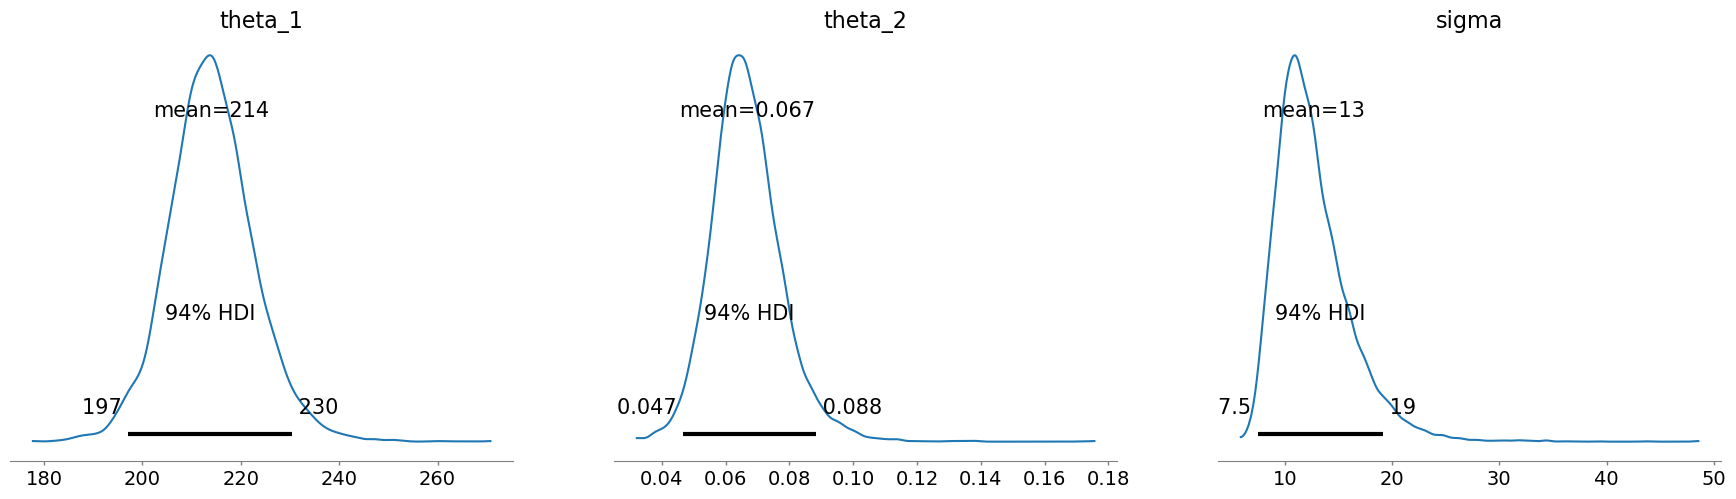

In [32]:
x_values = data["x"].values
y_values = data["y"].values

with pm.Model() as model:

    theta_1 = pm.HalfNormal("theta_1", sigma=1000)  
    theta_2 = pm.HalfNormal("theta_2", sigma=1)     
    sigma = pm.HalfNormal("sigma", sigma=50)      

    mu = (theta_1 * x_values) / (theta_2 + x_values)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_values)

    start_vals = {"theta_1": 200, "theta_2": 0.1, "sigma": 10}


    trace = pm.sample(
        2000,
        tune=1000,
        initvals=start_vals,          
        target_accept=0.95,
        return_inferencedata=True
    )

# Plot 
az.plot_posterior(trace, var_names=["theta_1", "theta_2", "sigma"])
plt.show()


#### **(b)** Provide evidence that your model has converged, whether it is a trace plot, lack of divergences, the Gelman-Rubin statistic (Rhat), or something else.

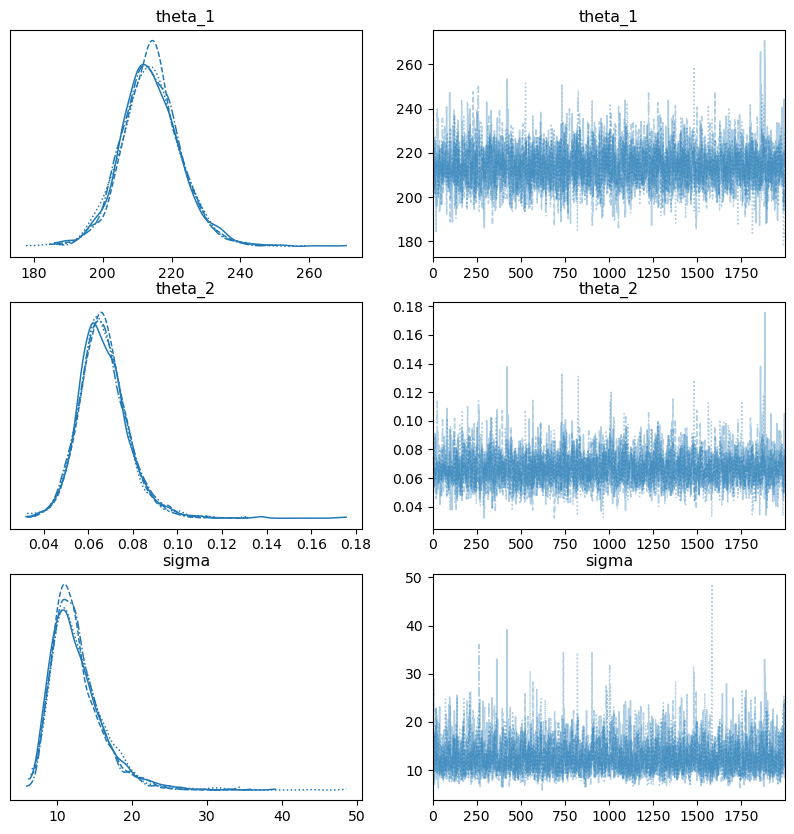

            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta_1  214.044  8.782  197.090  230.429      0.164    0.163    2990.0   
theta_2    0.067  0.011    0.047    0.088      0.000    0.000    2913.0   
sigma     12.642  3.477    7.501   19.150      0.066    0.092    2922.0   

         ess_tail  r_hat  
theta_1    2951.0    1.0  
theta_2    3118.0    1.0  
sigma      3313.0    1.0  


In [33]:
az.plot_trace(trace, var_names=["theta_1", "theta_2", "sigma"], figsize=(10, 10))
plt.show()

summary = az.summary(trace, var_names=["theta_1", "theta_2", "sigma"])
print(summary)

##### **The model has no divergences and R-hat is 1.0 for all parameters**

#### **(c)** Compute 95% credible intervals, the mean, and the standard deviation for each of the three parameters. (From now on, we will rarely specify which type of credible interval—you may use the default for your chosen software.)

In [34]:

summary_df = az.summary(trace, var_names=["theta_1", "theta_2", "sigma"], round_to=3)

credible_intervals = summary_df[["mean", "sd", "hdi_3%", "hdi_97%"]]

print(credible_intervals)


            mean     sd   hdi_3%  hdi_97%
theta_1  214.044  8.782  197.090  230.429
theta_2    0.067  0.011    0.047    0.088
sigma     12.642  3.477    7.501   19.150


### (d) Plot the posterior predictive distribution of y when x = 0.75 and provide the 95% credible intervals

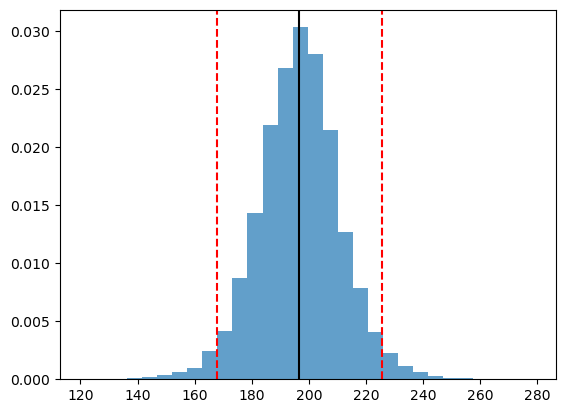

196.6241025769031 [167.95107826 225.75203573]


In [ ]:
x_new = 0.75

theta_1 = trace.posterior["theta_1"].values.flatten()
theta_2 = trace.posterior["theta_2"].values.flatten()
sigma = trace.posterior["sigma"].values.flatten()

y_pred = (theta_1 * x_new) / (theta_2 + x_new) + np.random.normal(0, sigma)
y_mean, y_hdi = np.mean(y_pred), np.percentile(y_pred, [2.5, 97.5])

# Plot
plt.hist(y_pred, bins=30, density=True, alpha=0.7)
plt.axvline(np.percentile(y_pred, 2.5), color="red", linestyle="dashed")
plt.axvline(np.percentile(y_pred, 97.5), color="red", linestyle="dashed")
plt.axvline(np.mean(y_pred), color="black")
plt.show()

print(y_mean, y_hdi)
